# Demo: estimating boundaries from trained ConvNet

- geoffroy.peeters@telecom-paris.fr
- 2022/06/08

In [5]:
import torch
from extract_audiofeatures import F_get_audio_features_sub
from dataset import F_slice_into_patches
from train_model import F_do_norm_meanstd
from model import CohenConvNet

<All keys matched successfully>

## Extract audio features

In [28]:
audio_file = '/tsi/clusterhome/gpeeters/M2-ATIAM-internship/music-structure-estimation//_references/rwc-pop/audio/RM-P001.wav'
LMS_data_m, LMS_time_sec_v, SSMmfcc_data_m, SSMmfcc_time_sec_v, SSMchroma_data_m, SSMchroma_time_sec_v = F_get_audio_features_sub(audio_file)

computing /tsi/clusterhome/gpeeters/M2-ATIAM-internship/music-structure-estimation//_references/rwc-pop/audio/RM-P001.wav


In [7]:
LMS_data_m = F_do_norm_meanstd(LMS_data_m)
SSMmfcc_data_m = F_do_norm_meanstd(SSMmfcc_data_m)
SSMchroma_data_m = F_do_norm_meanstd(SSMchroma_data_m)

## Compute patches

In [29]:
nb_frame = LMS_data_m.shape[1]
patch_halfduration_frame = 52
patch_hop_frame = int(patch_halfduration_frame/32)
patch_info_l = F_slice_into_patches(patch_hop_frame, patch_halfduration_frame, nb_frame, 0)
        

## Load pre-trained ConvNet model

In [ ]:
load_best_file = './weight/aes2017_best.pt'
model = CohenConvNet()
model.load_state_dict(torch.load(load_best_file, map_location=torch.device('cpu')), strict=False)

## Inference for each patch 

In [30]:
time_l = []
hat_is_boundary_l = []
for patch_info in patch_info_l:
    s = patch_info['start_frame']
    e = patch_info['end_frame']        
    data_m = torch.from_numpy(LMS_data_m[:,s:e])[None,None,:,:].float()
    SSM_data_m = torch.cat((torch.from_numpy(SSMmfcc_data_m[s:e,s:e])[None,None,:,:], torch.from_numpy(SSMchroma_data_m[s:e,s:e])[None,None,:,:]), 1).float()
    hat_is_boundary = model(data_m, SSM_data_m)

    time_l.append(patch_info['middle_frame'])
    hat_is_boundary_l.append(hat_is_boundary.item())

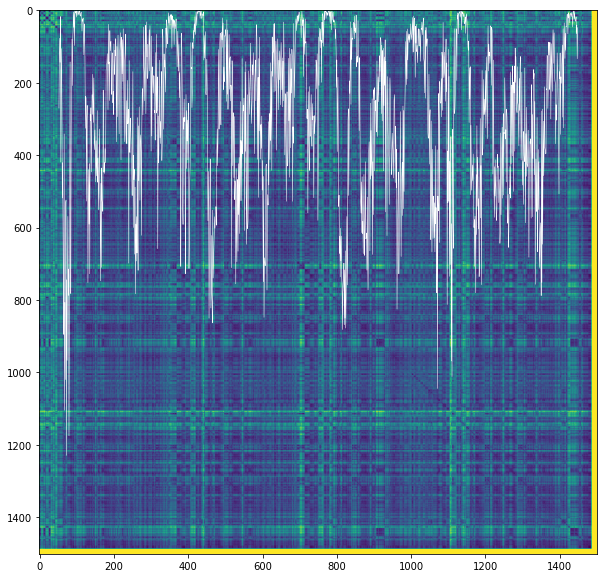

In [31]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10));
plt.imshow(SSMchroma_data_m, aspect='auto');
plt.plot(np.asarray(time_l), np.asarray(hat_is_boundary_l)*nb_frame, 'w', linewidth=0.5);